# Import

In [1]:
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.circuit import Circuit
from openfermion.utils.operator_utils import count_qubits

from utils.func import *
from utils.term_grouping import *
from utils.min_clique import *
from utils.hamlib import *
from utils.evol_real import *
from utils.plot import *
from utils.driver import *
from utils.JW import *

import numpy as np
import matplotlib.pyplot as plt

def gen_sys_param(n=10, sample_steps=100000, N=1):
    global t_max
    global initial_state_circ
    global n_qdrift_steps
    global sample_space
    global seg

    t_max=2
    seg = N
    initial_state_circ = Circuit(n)
    n_qdrift_steps = sample_steps
    sample_space = np.arange(0,sample_steps+1,1)

# Hydrogen chain

In [2]:
driver = PySCFDriver_custom()
bond_length = 1.0
n_sites = 3
driver.load_molecule(
    atom=[('H', (0, 0, i * bond_length)) for i in range(n_sites)], # Create a molecular data object for the hydrogen chain
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=1,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
print(n_qubits)
number, coulomb, excitation, no_excitation, double_excitation = JW_transformation(operator)

number_op, number_co = convert_op_to_input(number,n_qubits)
excitation_op, excitation_co = convert_op_to_input(excitation,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)

max_part_group = [[number_op[0], number_op[-2], excitation_op[0], excitation_op[1]],number_op[2:4],[number_op[1], number_op[-1], excitation_op[-2],excitation_op[-1]]]
max_coeff = [[(number_co[0]+number_co[-2]+abs(excitation_co[0])*2)/4],[number_co[2]],[(number_co[0]+number_co[-2]+abs(excitation_co[0])*2)/4]]

H_matrix = get_Hmatrix(number_op+excitation_op,n_qubits,number_co+excitation_co)

converged SCF energy = -1.52399620024611
6


In [3]:
gen_sys_param(n=n_qubits,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+excitation_op,number_co+excitation_co,t_max,n_qdrift_steps, seg)
U2p,secdepth = drift_time_evolution.trotter(order=2)

In [4]:
gen_sys_param(n=n_qubits,sample_steps=200)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+excitation_op,number_co+excitation_co,t_max,n_qdrift_steps, seg)
Ut,ldepth = drift_time_evolution.trotter(protected=False)

In [5]:
gen_sys_param(n=n_qubits,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+excitation_op,number_co+excitation_co,t_max,n_qdrift_steps, seg)
U2,secdepth = drift_time_evolution.trotter(order=2,protected=False)

In [6]:
gen_sys_param(n=n_qubits)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,max_part_group,max_coeff,t_max,n_qdrift_steps, seg)
Um,sm,mdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1])

In [7]:
gen_sys_param(n=n_qubits)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[number_op,excitation_op],[number_co,excitation_co],t_max,n_qdrift_steps, seg)
Ug,sg,gdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1])

In [12]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+excitation_op],[[c] for c in number_co+excitation_co],t_max,n_qdrift_steps,seg)
Uq,sq,qdepth = drift_time_evolution_parity.Drift_exp(depth=secdepth[-1])

In [13]:
U = [U2p,Ut,U2,Um,Ug,Uq]
depth = [secdepth,ldepth,secdepth,mdepth,gdepth,qdepth]
labels = ['second protected','lie','second','max group','group','qdrift'] 

In [14]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps,t_max, H_matrix)

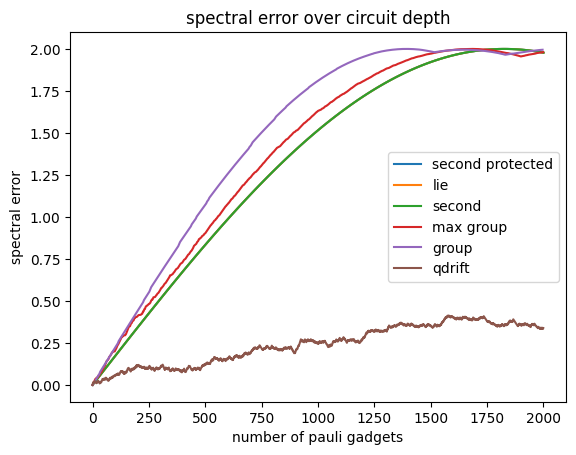

In [15]:
compare_spectral_error(depth,U,Uexc,labels)